In [49]:
import pandas as pd
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import sklearn
import time
from sklearn import *
import re
from tqdm import*
import warnings
import catboost as ctb
import lightgbm as lgbm
warnings.filterwarnings('ignore')
tqdm.pandas()
import plotly.figure_factory as ff
import requests as r
from collections import*
plt.style.use('ggplot')

In [2]:

df = pd.read_csv('avito_data_clean.csv')

In [3]:
df.clean = df.street + ' '+ df.dom.astype('str')

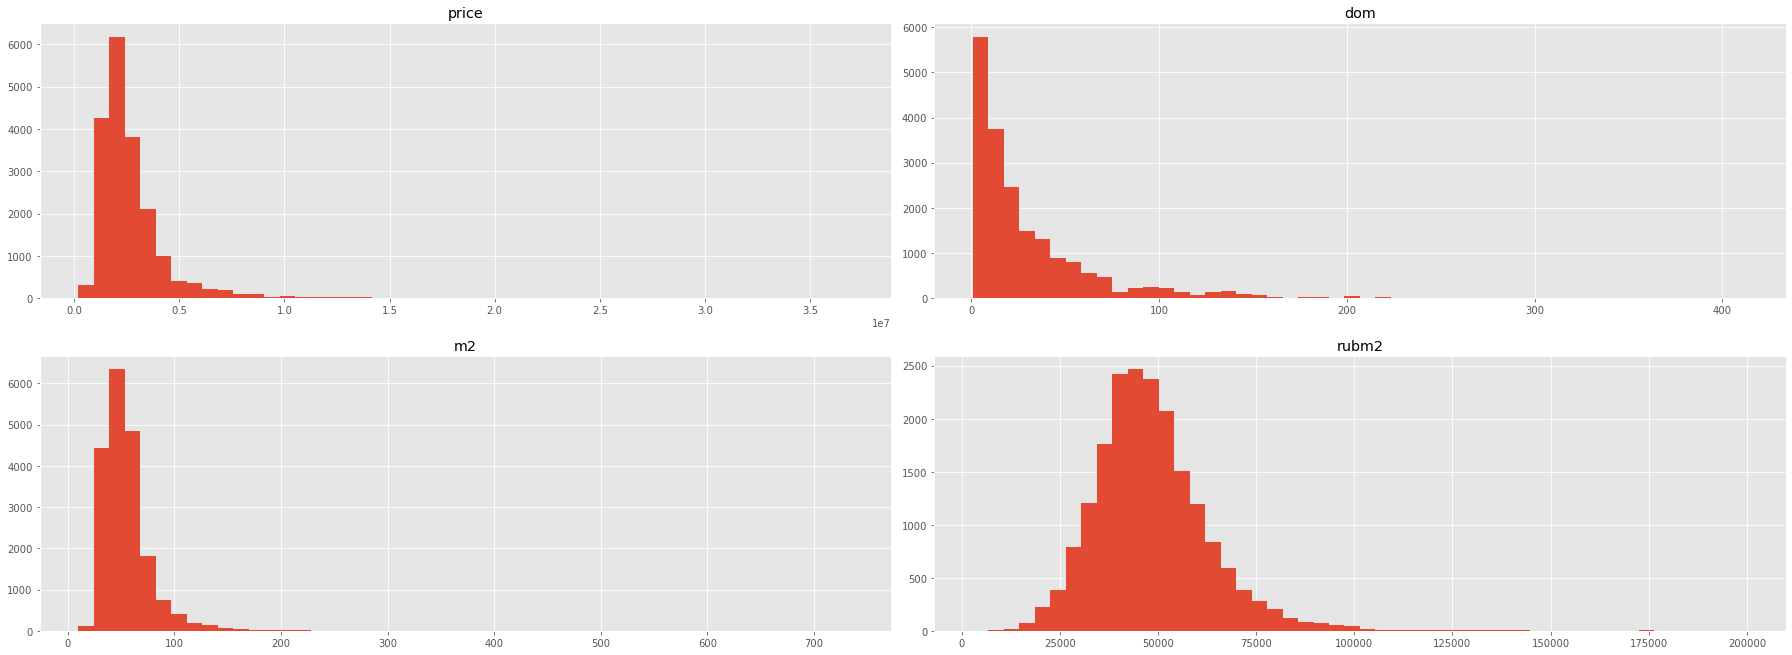

In [87]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['price', 'dom', 'm2', 'rubm2']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].hist(bins=50,ax=ax)
  plt.tight_layout()

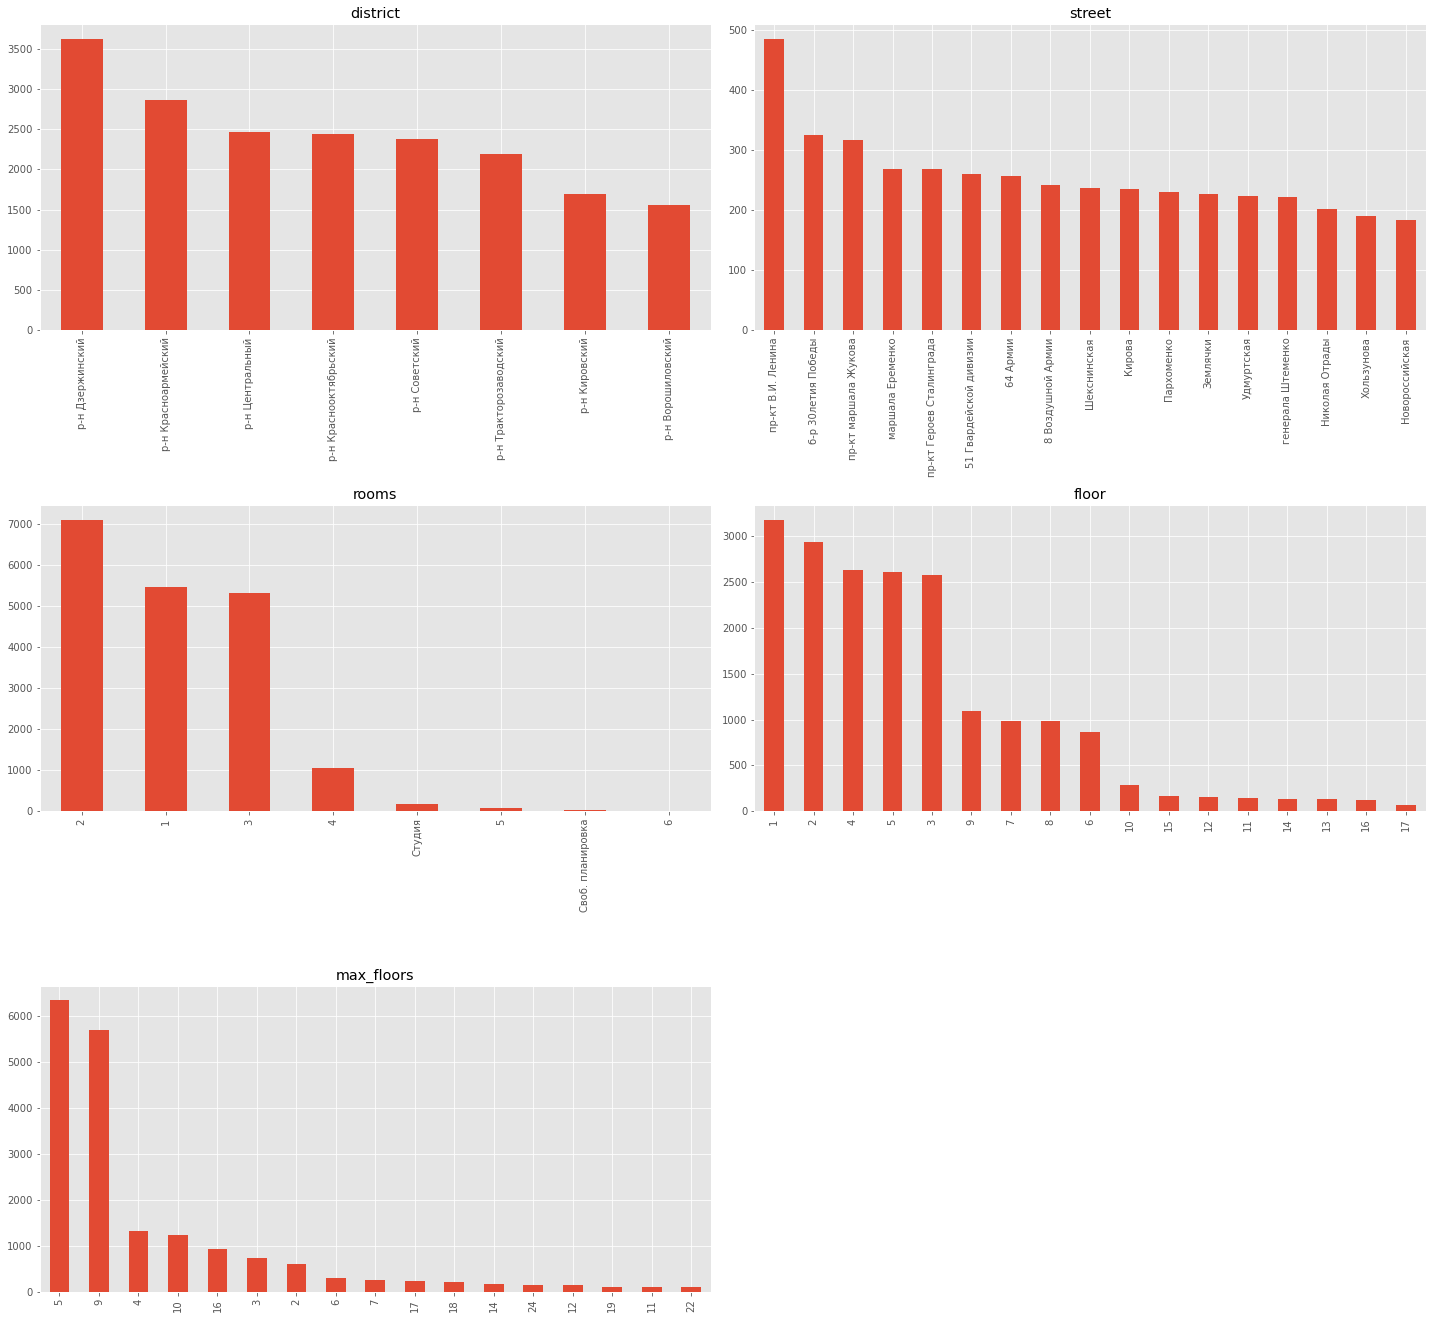

In [85]:
fig = plt.figure(figsize=(20,50*2.5))
for j,column in tqdm_notebook(enumerate(df[['district','street',
       'rooms', 'floor','max_floors']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].value_counts()[:17].plot.bar(ax=ax)
  plt.tight_layout()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000183F616D3C8>,
      dtype=object)

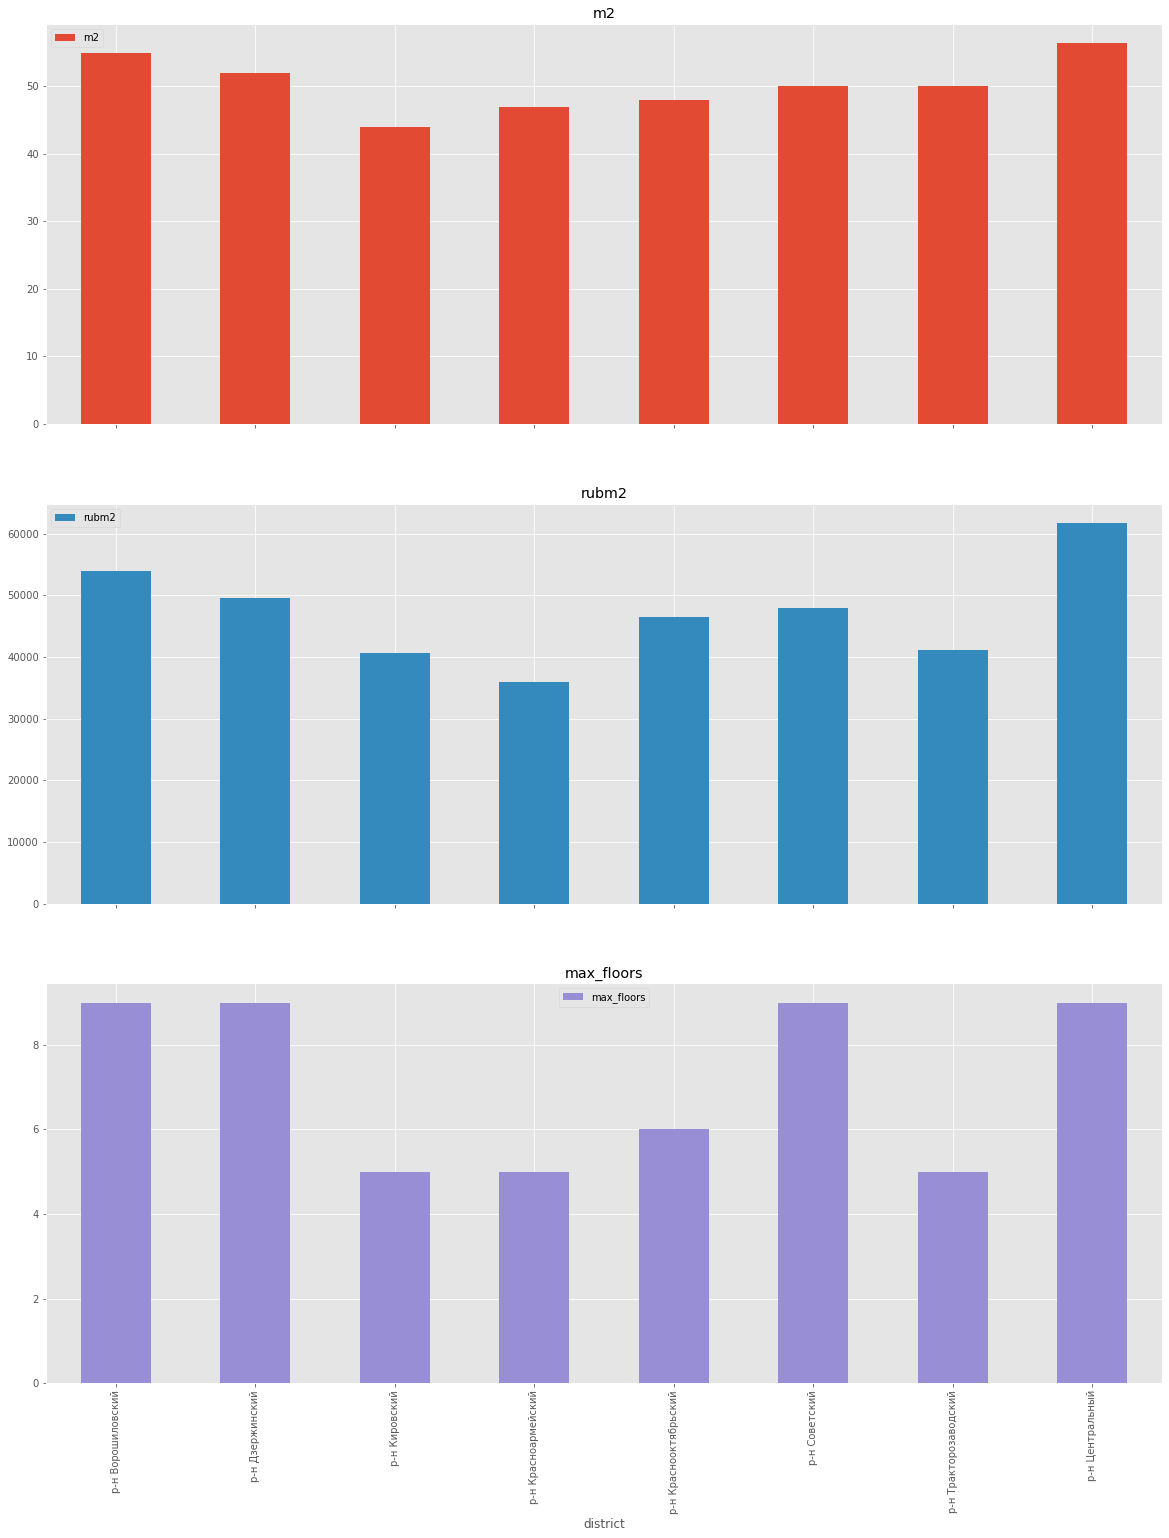

In [125]:
df.groupby(['district'])[['m2','rubm2','max_floors']].median().plot.bar(subplots=True,figsize=(20,25))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018384066388>,
      dtype=object)

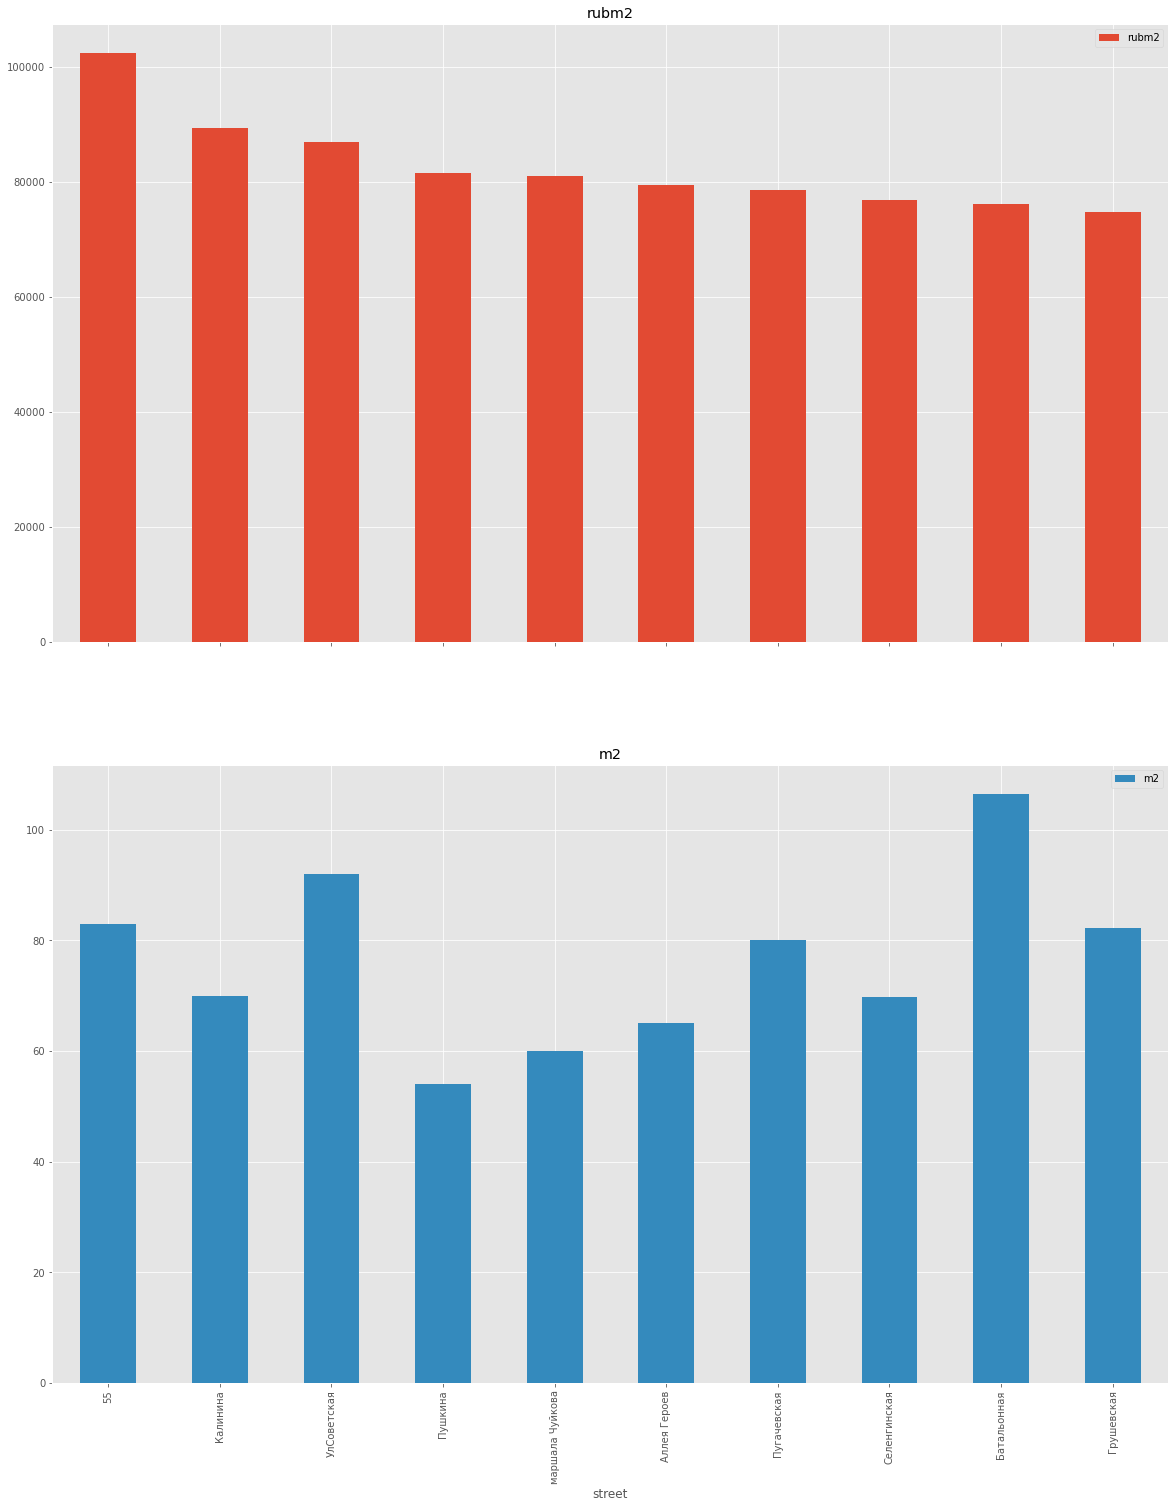

In [135]:
df.groupby('street')['rubm2','m2'].median().sort_values(by='rubm2',ascending=False)[:10].plot.bar(subplots=True,figsize=(20,25))

In [9]:
df.district=df.district.fillna('Missed')

In [110]:
df.head()

,adress,info,price,district,date,street,dom,clean,rooms,m2,floor,max_floors,rubm2,m2_range,rub_by_district,count_by_district,count_by_street
0,"Советский район, Горьковский, Волгоградская, 162","1-к квартира, 32 м², 1/2 эт.",970000,р-н Советский,2020-04-06,Волгоградская,162,Волгоградская 162,1,32.0,1,2,30312.500000,"(30.0, 57.8]",38064.537811,21.0,3
1,"Хользунова, 18/3","1-к квартира, 40 м², 16/17 эт.",2000000,р-н Краснооктябрьский,2020-04-06,Хользунова,18,Хользунова 18,1,40.0,16,17,50000.000000,"(30.0, 57.8]",49220.430376,14.0,12
2,"Аэропорт, 16","1-к квартира, 30.3 м², 2/5 эт.",1290000,р-н Дзержинский,2020-03-06,Аэропорт,16,Аэропорт 16,1,30.3,2,5,42574.257426,"(30.0, 57.8]",49553.039306,251.0,3
3,"Лавочкина, 7","1-к квартира, 41 м², 8/22 эт.",3050000,р-н Ворошиловский,2020-04-06,Лавочкина,7,Лавочкина 7,1,41.0,8,22,74390.243902,"(30.0, 57.8]",67969.975551,12.0,12
4,"Волгоград, Богунская, 12","1-к квартира, 32.4 м², 3/9 эт.",1700000,р-н Краснооктябрьский,2020-04-06,Богунская,12,Богунская 12,1,32.4,3,9,52469.135802,"(30.0, 57.8]",52763.382062,219.0,2


In [97]:
df['m2_range']=pd.cut(df.m2,bins=[0,30,57.8,88,116,df.m2.max()])

In [98]:
df['rub_by_district']=df.groupby(['district','rooms','max_floors'])['rubm2'].transform('mean')

In [99]:
gb_distr_rubm2=df.groupby(['district','rooms','max_floors'])['rubm2'].mean().rename('rub_by_district').reset_index()

In [100]:
gb_distr_count=df.groupby(['district','rooms','max_floors']).clean.count().rename('count_by_district').reset_index()

In [101]:
gb_street_count=df.groupby(['street','rooms','max_floors']).clean.count().rename('count_by_street').reset_index()

In [102]:
df['count_by_district']=df.groupby(['district','rooms','max_floors']).clean.transform('count')

In [103]:
df['count_by_street']=df.groupby(['street','rooms','max_floors']).clean.transform('count')

In [104]:
df.date=df.date.str.split(expand=True)[[0,1]].astype('str').apply(' '.join,axis=1)

In [105]:
df.date=df.date.replace('nan nan','4 июня')
df.date=df.date.str.replace(' июня',"/06/2020")
df.date= df.date.str.replace(' мая','/05/2020')
df.date= df.date.str.replace(' апреля','/04/2020')
df.date=pd.to_datetime(df.date)

In [106]:
df.groupby('district').mean()

,price,dom,m2,floor,max_floors,rubm2,rub_by_district,count_by_district,count_by_street
district,,,,,,,,,
р-н Ворошиловский,3.584823e+06,20.909383,60.953599,5.102185,9.334833,56881.723971,56881.723971,102.832905,11.145244
р-н Дзержинский,2.930188e+06,36.248826,57.671030,4.987296,8.745374,50814.496547,50814.496547,228.576912,19.630213
р-н Кировский,1.942112e+06,57.600711,47.434301,3.786730,6.459716,41658.818104,41658.818104,124.071090,21.342417
р-н Красноармейский,1.873896e+06,31.444095,50.992907,3.905660,6.619147,36767.730519,36767.730519,272.648498,20.829490
р-н Краснооктябрьский,2.424722e+06,37.020483,51.919009,4.444490,7.457190,47102.852728,47102.852728,207.785744,20.164687
р-н Советский,2.599414e+06,20.659100,53.315427,4.662463,7.874317,48723.446897,48723.446897,142.753678,12.605717
р-н Тракторозаводский,2.109681e+06,22.989977,51.119271,4.188155,7.028246,41710.082507,41710.082507,166.211845,19.054670
р-н Центральный,4.299788e+06,18.964605,64.864443,5.890561,10.214809,64466.039401,64466.039401,107.873881,16.072823


In [107]:
data = df.drop(['price','rubm2','clean','date','info','adress'],axis=1)
targ = df['price']

In [21]:
d_=collections.defaultdict(preprocessing.LabelEncoder)

In [22]:
data_mani = data.copy()

In [23]:
data_mani.loc[:,data_mani.select_dtypes(include=['category','O']).columns] = data_mani.progress_apply(lambda x: d_[x.name].fit_transform(x) if x.dtype not in [float,int] else x)

100%|██████████| 11/11 [00:00<00:00, 111.26it/s]


In [24]:
data_mani

,district,street,dom,rooms,m2,floor,max_floors,m2_range,rub_by_district,count_by_district,count_by_street
0,6,95,162,0,32.0,1,2,1,38064.537811,21,3
1,5,441,18,0,40.0,16,17,2,49220.430376,14,12
2,2,52,16,0,30.3,2,5,1,49553.039306,251,3
3,1,248,7,0,41.0,8,22,2,67969.975551,12,12
4,5,73,12,0,32.4,3,9,1,52763.382062,219,2
...,...,...,...,...,...,...,...,...,...,...,...
19247,8,364,38,3,150.0,4,9,7,55620.030259,45,13
19248,2,21,30,7,21.7,7,10,0,62727.534869,6,6
19249,4,19,40,3,198.6,3,9,7,36258.636421,53,2
19250,1,186,2,3,114.0,21,27,6,89473.684211,2,2


In [395]:
x,xv,y,yv = model_selection.train_test_split(data_mani,targ,test_size= 0.2)

In [362]:
x.head()

,district,street,dom,rooms,m2,floor,max_floors,m2_range,rub_by_district,count_by_district,count_by_street
6422,5,87,8,3,75.5,5,5,4,41496.410808,187,3
11869,2,102,14,1,35.0,5,5,1,49553.039306,251,6
18600,5,357,62,4,84.0,8,10,4,49101.286836,9,1
908,5,31,3,1,38.0,7,9,1,52763.382062,219,8
17309,4,127,16,3,63.6,7,9,3,40472.837963,330,35


In [363]:
import lightgbm as lgbm

In [25]:
ts = lgbm.Dataset(data_mani,targ)

In [26]:
par ={'n_estimators':5000,
     "objective" : "regression",
        "metric" : "rmse",
     'verbose':200}

In [44]:
lgb_cv = lgbm.cv(params=par,train_set=ts,nfold=3,stratified=False)

In [68]:
pd.DataFrame(lgb_cv).sort_values(by='rmse-mean')

,rmse-mean,rmse-stdv
4979,4.683431e+05,29691.119855
4999,4.683437e+05,29696.529040
4978,4.683440e+05,29690.399653
4980,4.683465e+05,29691.533769
4998,4.683470e+05,29689.164931
...,...,...
4,1.268410e+06,41731.738054
3,1.359366e+06,41367.382104
2,1.462046e+06,41309.539098
1,1.580828e+06,40422.995580


In [47]:
lgb_cv['rmse-mean'][-1]

468343.72109435877

In [69]:
lgb = lgbm.LGBMRegressor(n_estimators=5000)
lgb.fit(data_mani,targ,verbose=200)

LGBMRegressor(n_estimators=5000)

In [365]:
def score_comp(booster,dic,values=None,predict=True):
    for i in [metrics.r2_score,metrics.mean_absolute_error,metrics.max_error]:
        if predict==True:
            dic[booster.__class__.__name__].append(i(yv,booster.predict(xv)))
        else:
            dic[booster].append(i(yv,values))

In [366]:
score = defaultdict(list)

In [367]:
score_comp(lgb,score)

In [54]:
from bayes_opt import BayesianOptimization

In [51]:
X_train=data_mani # analysing data
y_train=targ #analysing target
categorical_features=[] #categorical features in set
#num of parametrs must match in lgb_eval & optimisition
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,
             min_child_samples,
             mcw,
             #min_data_in_leaf,
             #n_estimators,
             lr):
    #parametrs for tuning
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        #'device':'gpu'
        'min_child_weight':mcw,
        'is_unbalance': False,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "min_child_samples" : int(min_child_samples),
       # 'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : lr,
        #'n_estimators':int(n_estimators)
    }
    lgtrain = lgbm.Dataset(X_train, y_train)
    #testing feature, almost always some kind of cv
    cv_result = lgbm.cv(params,
                       lgtrain,
                       5000,
                       early_stopping_rounds=500,
                       stratified=False,
                       nfold=3)
    return -cv_result['rmse-mean'][-1]

In [49]:
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 5000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [55]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (1, 4000),
                                                'max_depth': (-1, 63),
                                                'lambda_l2': (0.0, 10),
                                                'lambda_l1': (0.0, 10),
                                                'min_child_samples': (5, 100),
                                        'mcw':(0.0001,0.1),
                                                'lr':(0.0001,0.3)
                                                })

lgbBO.maximize(n_iter=25, init_points=25)

|   iter    |  target   | lambda_l1 | lambda_l2 |    lr     | max_depth |    mcw    | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -5.409e+0 |  7.729    |  5.41     |  0.03034  |  14.21    |  0.06928  |  68.51    |  2.129e+0 |
|  2        | -4.686e+0 |  2.435    |  2.588    |  0.07932  |  30.67    |  0.009091 |  24.33    |  2.317e+0 |
|  3        | -6.368e+0 |  8.587    |  4.273    |  0.01085  |  40.59    |  0.02486  |  99.48    |  1.684e+0 |
|  4        | -5.196e+0 |  3.044    |  9.889    |  0.1966   |  44.58    |  0.03551  |  57.03    |  3.804e+0 |
|  5        | -5.268e+0 |  7.908    |  2.497    |  0.2543   |  10.24    |  0.06781  |  93.97    |  2.318e+0 |
|  6        | -4.82e+05 |  7.414    |  0.298    |  0.128    |  37.79    |  0.01781  |  10.11    |  2.271e+0 |
|  7        | -4.801e+0 |  7.355    |  3.631    |  0.2297   |  43.18    |  0.05175  |  18.89    |  2.969e+0 |
|  8      

In [56]:
lgbBO.max

{'target': -466670.561515491,
 'params': {'lambda_l1': 3.1804673864798247,
  'lambda_l2': 6.091610716923955,
  'lr': 0.07996116870294002,
  'max_depth': 13.05529319859183,
  'mcw': 0.07576510019081709,
  'min_child_samples': 28.064906605116043,
  'num_leaves': 3225.1942194239496}}

In [57]:
lgbBO.max['params']

{'lambda_l1': 3.1804673864798247,
 'lambda_l2': 6.091610716923955,
 'lr': 0.07996116870294002,
 'max_depth': 13.05529319859183,
 'mcw': 0.07576510019081709,
 'min_child_samples': 28.064906605116043,
 'num_leaves': 3225.1942194239496}

,LGBMRegressor
0,9.225475e-01
1,2.401821e+05
2,1.026308e+07


In [370]:
cat = ctb.CatBoostRegressor(iterations = 5000, verbose=200,
                                early_stopping_rounds=500,
                               cat_features=[0,1,2,3,5,6,7]
                           )

In [371]:
cat.fit(x,y,eval_set=(xv,yv))

Learning rate set to 0.028345
0:	learn: 1841334.7932865	test: 1757146.3986411	best: 1757146.3986411 (0)	total: 8.68ms	remaining: 43.4s
200:	learn: 614991.6082870	test: 630575.6447906	best: 630575.6447906 (200)	total: 1.08s	remaining: 25.7s
400:	learn: 546190.0927937	test: 592371.9831854	best: 592371.9831854 (400)	total: 2.38s	remaining: 27.3s
600:	learn: 503272.2239657	test: 573884.5581434	best: 573884.5581434 (600)	total: 3.52s	remaining: 25.8s
800:	learn: 468504.1794594	test: 549896.3809385	best: 549893.1403751 (799)	total: 4.65s	remaining: 24.4s
1000:	learn: 443751.2284357	test: 532539.9407613	best: 532539.9407613 (1000)	total: 5.81s	remaining: 23.2s
1200:	learn: 424675.2955527	test: 521939.7969263	best: 521939.7969263 (1200)	total: 6.98s	remaining: 22.1s
1400:	learn: 409099.7040994	test: 513630.0915744	best: 513630.0915744 (1400)	total: 8.16s	remaining: 21s
1600:	learn: 394537.7644344	test: 505444.1635427	best: 505444.1635427 (1600)	total: 9.34s	remaining: 19.8s
1800:	learn: 382586

In [372]:
score_comp(cat,score)

In [373]:
pd.DataFrame(score).style

,LGBMRegressor,CatBoostRegressor
0,0.922548,0.934328
1,240182.129898,262395.292703
2,10263080.952621,8162791.630150


In [63]:
def predict_price(data=None,log1p=False):
    if data!= None:
        d=data
        d['m2_range']=df['m2_range'].unique()[[(d['m2'] in i ) for i in df['m2_range'].unique()]][0]
    else:
        d = collections.defaultdict(list)
        for info in cat.feature_names_[:-4]:
            print( f'Input {info}, example :{df[info].unique()[:3]}')
            d[info] = input()
        d['max_floors']=int(d['max_floors'])
        d['m2']=int(d['m2'])
        d['m2_range']=df['m2_range'].unique()[[(d['m2'] in i ) for i in df['m2_range'].unique()]][0]
    #d['clean'] = d['street'] + ','+str(d['dom'])
    d['street'] = df[df.street.str.contains(d['street'])].street.mode()[0]
    home_df = pd.DataFrame(d,index=[0])
    for i in [gb_distr_rubm2,gb_distr_count,gb_street_count]:
        home_df = home_df.merge(i, how='left',on=i.columns[:-1].to_list())
    try:
        cat_df=home_df.apply(lambda x: d_[x.name].transform(x) if x.name in list(d_.keys()) else x)
    except:
        try:
            street = df[df.street.str.contains(d['street'])].street.mode()[0]
            idx_nearest=df.query('street==@street')['dom'].apply(lambda x: abs(x-d['dom'])).sort_values()[:1].index[0]
            home_df.loc[0,'dom'] = df['dom'].loc[idx_nearest]
            home_df['clean'] = home_df['street'] + ','+home_df['dom'].astype(str)
            print('some info from : ',home_df['clean'][0])
            cat_df=home_df.apply(lambda x: d_[x.name].transform(x) if x.name in list(d_.keys()) else x)
        except:
            gb__=df.groupby(['district','rooms','max_floors'])['clean'].apply(pd.Series.mode).reset_index().drop('level_3',axis=1)
            home_df=home_df.merge(gb__,how='left',on=gb__.columns.to_list()[:-1])
            home_df[['street','dom']] = home_df.clean.str.split(',',expand=True)
            print('some info from : ',home_df['clean'][0])
            cat_df=home_df.apply(lambda x: d_[x.name].transform(x) if x.name in list(d_.keys()) else x)
    #cat_df = cat_df[cat.feature_names_]
    price=lgb.predict(cat_df)
    return(price)

In [70]:
d_tr= {}

In [71]:
d_tr['district'] = 'р-н Краснооктябрьский'
d_tr['street'] = 'Триумфальная'
d_tr['dom'] = 24
d_tr['rooms'] = '3'
d_tr['m2'] = 68
d_tr['floor'] = 7
d_tr['max_floors'] = 9

In [72]:
predict_price(d_tr)

array([3283847.2314975])

In [73]:
d_pod = {}
d_pod['district'] = 'р-н Краснооктябрьский'
d_pod['street'] = 'Поддубного'
d_pod['dom'] = 29
d_pod['rooms'] = '2'
d_pod['m2'] = 42
d_pod['floor'] = 5
d_pod['max_floors'] = 5

In [74]:
predict_price(d_pod)


array([1829891.04082938])

In [79]:
d_ere= {}
d_ere['district'] = 'р-н Краснооктябрьский'
d_ere['street'] = 'Еременко'
d_ere['dom'] = 102
d_ere['rooms'] = '2'
d_ere['m2'] = 50
d_ere['floor'] = 4
d_ere['max_floors'] = 5

In [80]:
predict_price(d_ere)


array([2114487.06354057])

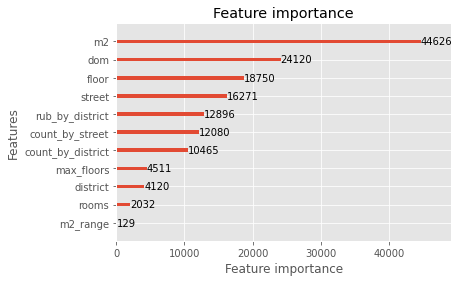

In [81]:
lgbm.plot_importance(lgb)

In [82]:
import shap

In [83]:
expl=shap.TreeExplainer(lgb)

In [84]:
shap_val=expl.shap_values(data_mani,targ)

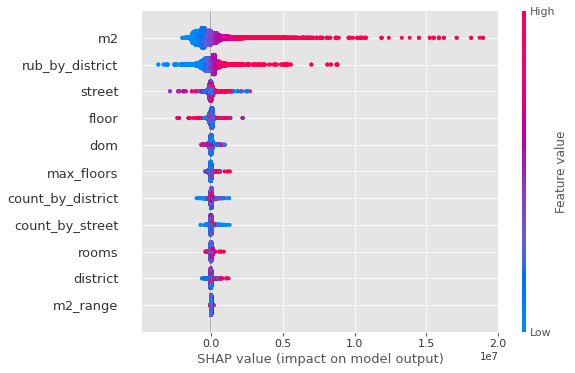

In [88]:
shap.summary_plot(shap_val,data_mani)

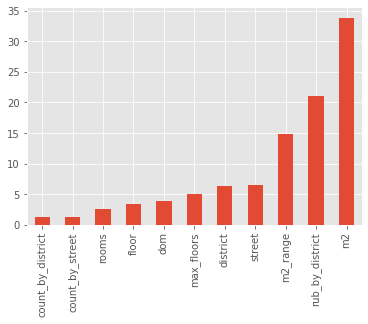

In [184]:
pd.Series(cat.feature_importances_,cat.feature_names_).sort_values().plot.bar()

In [327]:
blend = cat.predict(xv)*.5+lgb.predict(xv)*.5

In [332]:
score_comp('blend',score,values=blend,predict=False)

In [335]:
pd.DataFrame(score)

,LGBMRegressor,CatBoostRegressor,blend
0,9.462648e-01,9.226506e-01,9.430055e-01
1,1.659373e+05,2.728754e+05,2.080889e+05
2,1.068100e+07,1.085392e+07,1.014486e+07


In [ ]:
px.sunburst(
    df,
    path=['district','street','max_floors'],
    values='m2',
    height=800
)